In [3]:
from random import sample as rsample

import numpy as np

from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Dense, Flatten
from keras.optimizers import SGD, RMSprop

In [4]:
GRID_SIZE = 10

def episode():
    """ 
    Coroutine of episode. 
    
    Action has to be explicitly send to this coroutine.
    """
    x, y, z = (
        np.random.randint(0, GRID_SIZE),  # X of fruit
        0,  # Y of dot
        np.random.randint(1, GRID_SIZE - 1)  # X of basket
    )
    while True:
        X = np.zeros((GRID_SIZE, GRID_SIZE))  # Reset grid
        X[y, x] = 1.  # Draw fruit
        bar = range(z - 1, z + 2)
        X[-1, bar] = 1.  # Draw basket
        
        # End of game is known when fruit is at penultimate line of grid.
        # End represents either a win or a loss
        end = int(y >= GRID_SIZE - 2)
        if end and x not in bar:
            end *= -1
            
        action = yield X[np.newaxis], end    
        if end:
            break

        z = min(max(z + action, 1), GRID_SIZE - 2)
        y += 1

            
def experience_replay(batch_size):
    """
    Coroutine of experience replay.
    
    Provide a new experience by calling send, which in turn yields 
    a random batch of previous replay experiences.
    """
    memory = []
    while True:
        experience = yield rsample(memory, batch_size) if batch_size <= len(memory) else None
        memory.append(experience)

In [8]:
?RMSprop

In [12]:
nb_epochs = 100
batch_size = 128
epsilon = .1
gamma = 1.

# Recipe of deep reinforcement learning model
model = Sequential()
#model.add(Convolution2D(16, (3, 3), input_shape=(1, GRID_SIZE, GRID_SIZE), activation='relu',data_format='channels_first'))
#model.add(Convolution2D(16, (3,3), activation='relu',data_format='channels_first'))
model.add(Convolution2D(10, (3,3), input_shape=(1, GRID_SIZE, GRID_SIZE), activation='relu',data_format='channels_first'))
model.add(Convolution2D(10, (3,3), activation='relu',data_format='channels_first'))
model.add(Flatten(data_format='channels_first'))
model.add(Dense(100, activation='relu'))
model.add(Dense(3)) #3 actions
#model.compile(loss='mean_squared_error', optimizer=SGD())
model.compile(loss='mean_squared_error', optimizer=RMSprop())
exp_replay = experience_replay(batch_size)
exp_replay.__next__() # Start experience-replay coroutine

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 10, 8, 8)          100       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 6, 6)          910       
_________________________________________________________________
flatten_1 (Flatten)          (None, 360)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               36100     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 303       
Total params: 37,413
Trainable params: 37,413
Non-trainable params: 0
_________________________________________________________________


In [13]:
Loss = np.zeros((nb_epochs,))

for i in range(nb_epochs):
    ep = episode()
    S, won = ep.__next__()  # Start coroutine of single entire episode
    loss = 0.
    try:
        while True:
            action = np.random.randint(-1, 2) 
            if np.random.random() > epsilon:
                # Get the index of the maximum q-value of the model.
                # Subtract one because actions are either -1, 0, or 1
                action = np.argmax(model.predict(S[np.newaxis]), axis=-1)[0] - 1

            S_prime, won = ep.send(action)
            experience = (S, action, won, S_prime)
            S = S_prime
            
            batch = exp_replay.send(experience)
            if batch:
                inputs = []
                targets = []
                for s, a, r, s_prime in batch:
                    # The targets of unchosen actions are the q-values of the model,
                    # so that the corresponding errors are 0. The targets of chosen actions
                    # are either the rewards, in case a terminal state has been reached, 
                    # or future discounted q-values, in case episodes are still running.
                    t = model.predict(s[np.newaxis]).flatten()
                    t[a + 1] = r
                    if not r:
                        t[a + 1] = r + gamma * model.predict(s_prime[np.newaxis]).max(axis=-1)
                    targets.append(t)
                    inputs.append(s)
                
                loss += model.train_on_batch(np.array(inputs), np.array(targets))

    except StopIteration:
        pass
    
    Loss[i] = loss
    if (i + 1) % 10 == 0:
        print("Epoch {}, loss: {}".format(i + 1, loss))

Epoch 10, loss: 0.0
Epoch 20, loss: 0.29064271971583366
Epoch 30, loss: 0.47781794890761375
Epoch 40, loss: 1.9987860694527626
Epoch 50, loss: 15.437150329351425
Epoch 60, loss: 13.605914771556854
Epoch 70, loss: 26.14130401611328
Epoch 80, loss: 93.27194809913635
Epoch 90, loss: 74.59638929367065
Epoch 100, loss: 131.82960319519043


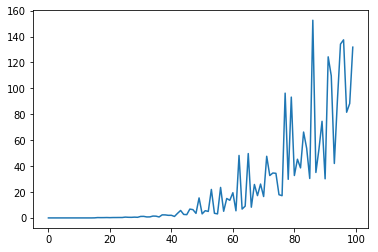

In [16]:
from matplotlib import pyplot as plt
plt.plot(Loss)
plt.show()